# Предсказание временных рядов


## 1. Скачать датасет Х.

In [120]:
from __future__ import division, print_function

from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import warnings

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize

from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

In [121]:
data = pd.read_csv('all_stocks_5yr.csv', index_col=0)
data.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


## Анализируем Амазон

In [122]:
df_amazon = data[data.Name == 'AMZN']

In [123]:
df_amazon_close = df_amazon[ ['close'] ]
                             
#df1 = df[['a','b']]

In [124]:
df_amazon_close.index = pd.to_datetime(df_amazon_close.index)

In [125]:
df_amazon_close100 = df_amazon_close[0:100]

In [126]:
df_amazon_close100.head(2)

,close
date,
2013-02-08,261.95
2013-02-11,257.21


In [127]:
#open_price = data[data.Name == 'AMZN'].open.as_matrix()
#high_price = data[data.Name == 'AMZN'].high.as_matrix()
#low_price = data[data.Name == 'AMZN'].low.as_matrix()
close_price = data[data.Name == 'AMZN'].close.as_matrix()
#volume_ = data[data.Name == 'AMZN'].volume.as_matrix()

In [128]:
close_price = close_price[0:100]

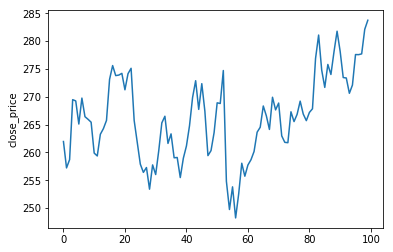

In [129]:
plt.plot(close_price)
plt.ylabel('close_price')
plt.show()

In [130]:
close_price.mean()

266.26568

In [131]:
close_price_s = pd.Series(close_price)

## Тест на стационарность

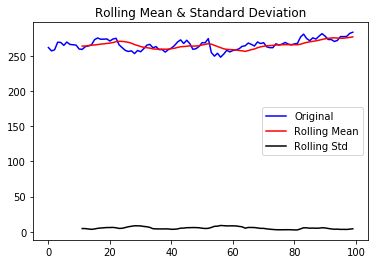

Results of Dickey-Fuller Test:
Test Statistic                 -2.494852
p-value                         0.116732
#Lags Used                      0.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [132]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Задаем скользящие
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Отрисовываем
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Выполняем тест Дики-Фуллера
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    
test_stationarity(close_price_s)

## Сглаживание

In [133]:
close_price_log = np.log(close_price_s)

In [134]:
close_price_log.shape

(100,)

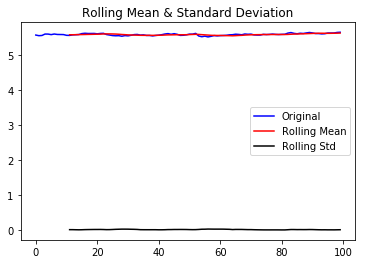

Results of Dickey-Fuller Test:
Test Statistic                 -2.523388
p-value                         0.109887
#Lags Used                      0.000000
Number of Observations Used    99.000000
Critical Value (1%)            -3.498198
Critical Value (5%)            -2.891208
Critical Value (10%)           -2.582596
dtype: float64


In [135]:
test_stationarity(close_price_log)

### Разность

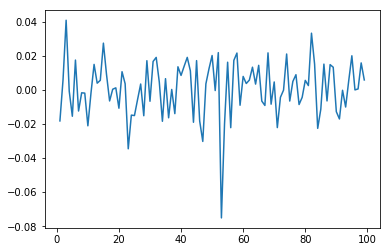

In [136]:
ts_log_diff = close_price_log - close_price_log.shift()
plt.plot(ts_log_diff)

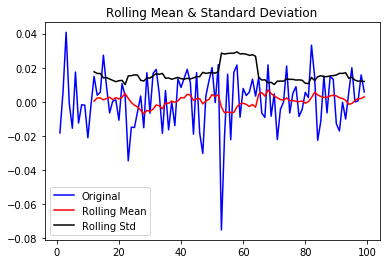

Results of Dickey-Fuller Test:
Test Statistic                -6.363612e+00
p-value                        2.440209e-08
#Lags Used                     4.000000e+00
Number of Observations Used    9.400000e+01
Critical Value (1%)           -3.501912e+00
Critical Value (5%)           -2.892815e+00
Critical Value (10%)          -2.583454e+00
dtype: float64


In [137]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

### Декомпозиция

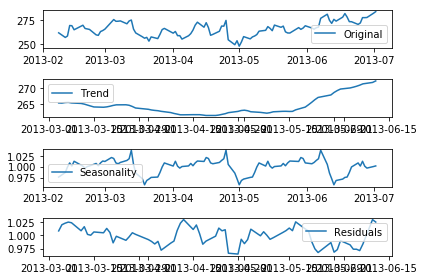

In [138]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_amazon_close100, model='multiplicative', freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(df_amazon_close100, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# ARIMA

In [139]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA  # (p,d,q)

In [140]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#lag_acf = acf(close_price_log, nlags=20)
#lag_pacf = pacf(close_price_log, nlags=20, method='ols')



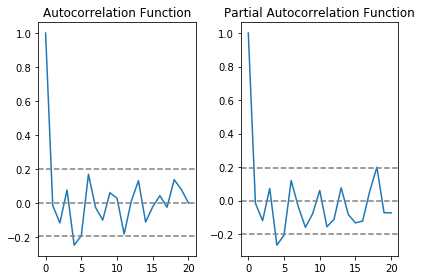

In [141]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')

#plt.axhline(y=-1.96/np.sqrt(len(close_price_log)),linestyle='--',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(close_price_log)),linestyle='--',color='gray')



plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')

#plt.axhline(y=-1.96/np.sqrt(len(close_price_log)),linestyle='--',color='gray')
#plt.axhline(y=1.96/np.sqrt(len(close_price_log)),linestyle='--',color='gray')


plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [158]:
q = 3
p = 18

In [159]:
#model = ARIMA(close_price_log, order=(p, 0, q))

model = ARIMA(close_price_log, order=(p, 1, q))  
results_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(15,15))
plt.plot(ts_log_diff)
#plt.plot(close_price_log)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-close_price_log)**2))

KeyboardInterrupt: 

Text(0.5, 1.0, 'RMSE: 12.5824')

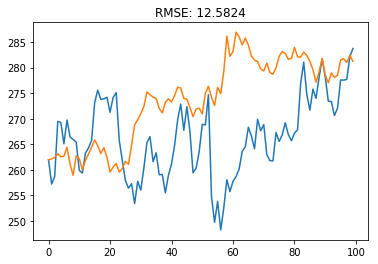

In [155]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(close_price_log.ix[0], index=close_price_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(close_price_s)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-close_price_s)**2)/len(close_price_s)))

In [137]:
import pmdarima as pm


In [28]:
p = range(0, 3)
d = (1,)
q = range(0, 2)

from itertools import product

parameters = product(p, d, q)
parameters_list = list(parameters)
len(parameters_list)

6

In [29]:
for p, d, q in parameters_list:
    model = ARIMA(close_price_log, order=(p, d, q))  
    results_ARIMA = model.fit(disp=-1)  
    rss = sum((results_ARIMA.fittedvalues - ts_log_diff)**2)
    print('for p={}, d={}, q={} RSS is {}'.format(p, d, q, rss))


for p=0, d=1, q=0 RSS is 0.12211430369198147
for p=0, d=1, q=1 RSS is 0.1217549908644108
for p=1, d=1, q=0 RSS is 0.12173913999850337
for p=1, d=1, q=1 RSS is 0.12173008840034873
for p=2, d=1, q=0 RSS is 0.12170450389547803
for p=2, d=1, q=1 RSS is 0.12161579276940508


In [30]:
model = ARIMA(close_price_log, order=(3, 1, 3))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.